# Audio Processing

In [80]:
import torch
import torchaudio
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

In [31]:
import os
from matplotlib import pyplot as plt
import glob
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import librosa
import random

In [3]:
swallow_file = os.path.join('..', 'data', 'processed', '1.wav')
not_swallow_file = os.path.join('..', 'data', 'sound_datasets', 'urbansound8k', 'audio', 'fold1', '7061-6-0-0.wav')

In [4]:
def process_audio_file(file_path):
    # Load the audio file
    waveform, sample_rate = torchaudio.load(file_path)

    # Convert to mono if the audio is in stereo format
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0).unsqueeze(0)

    # Resample the audio to 16000
    resampler = torchaudio.transforms.Resample(sample_rate, 16000)
    waveform = resampler(waveform)

    return waveform


In [5]:
wave = process_audio_file(swallow_file)
nwave = process_audio_file(not_swallow_file)

In [7]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

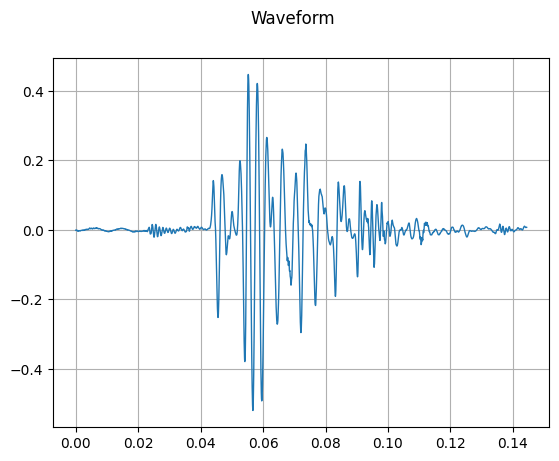

In [8]:
plot_waveform(wave, 16000)

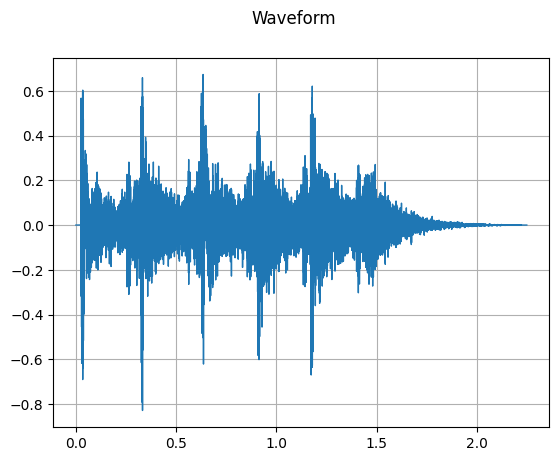

In [9]:
plot_waveform(nwave, 16000)

In [10]:
POS = os.path.join('..', 'data', 'processed')
pos = glob.iglob(POS + '/**/*.wav', recursive=True)


In [11]:
NEG = os.path.join('..', 'data', 'sound_datasets', 'urbansound8k', 'audio')
neg = glob.iglob(NEG + '/**/*.wav', recursive=True)

In [12]:
# Create a dataframe for positive samples
pos_df = pd.DataFrame({'file_path': list(pos), 'label': 1})

# Create a dataframe for negative samples
neg_df = pd.DataFrame({'file_path': list(neg), 'label': 0})

neg_df_downsampled = neg_df.sample(n=len(pos_df), random_state=42)

# Concatenate the dataframes
df = pd.concat([pos_df, neg_df_downsampled], ignore_index=True)


In [13]:
df

,file_path,label
0,../data/processed/16.wav,1
1,../data/processed/103.wav,1
2,../data/processed/117.wav,1
3,../data/processed/116.wav,1
4,../data/processed/102.wav,1
...,...,...
347,../data/sound_datasets/urbansound8k/audio/fold...,0
348,../data/sound_datasets/urbansound8k/audio/fold...,0
349,../data/sound_datasets/urbansound8k/audio/fold...,0
350,../data/sound_datasets/urbansound8k/audio/fold...,0


In [14]:
lengths = []
for file in os.listdir(POS):
    if file.endswith('.wav'):
        tensor_wave = process_audio_file(os.path.join(POS, file))
        lengths.append(len(tensor_wave[0]))

In [15]:
print(f'Min: {np.min(lengths)} \n Max: {np.max(lengths)} \n Mean: {np.mean(lengths)}')

Min: 1791 
 Max: 13019 
 Mean: 5133.619318181818


we standardize the number of values to 16000 tentatively (equivalent to 1s of audio)

In [32]:
def pad_trunc(wav, limit=16000):
    num_rows, sig_len = wav.shape

    if (sig_len > limit):
        # Truncate the signal to the given length
        wav = wav[:,:limit]

    elif (sig_len < limit):
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, limit - sig_len)
        pad_end_len = limit - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        wav = torch.cat((pad_begin, wav, pad_end), 1)
        
    return wav

In [68]:
# Convert the dataset to a PyTorch dataset
class AudioDataset(Dataset):
    def __init__(self, dataset):
        self.data = dataset
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        file_path, label = self.data.iloc[index]
        
        waveform = process_audio_file(file_path)
        waveform = pad_trunc(waveform)
        transform = torchaudio.transforms.MelSpectrogram(n_fft=16000, pad=16000-waveform.shape[1])
        spectrogram = transform(waveform)
        
        return spectrogram, label

In [17]:
swallow_file2 = os.path.join('..', 'data', 'processed', '106.wav')

In [62]:
waveform = process_audio_file(swallow_file)
waveform = pad_trunc(waveform)
transform = torchaudio.transforms.MelSpectrogram(n_fft=16000)
spectrogram = transform(waveform)

Shape: (1, 128, 3)
Dtype: torch.float32
 - Max:     36651.855
 - Min:      0.000
 - Mean:    698.935
 - Std Dev: 3900.914

tensor([[[0.0000e+00, 1.8415e+00, 3.7201e+02],
         [0.0000e+00, 4.3178e+00, 5.6155e+02],
         [0.0000e+00, 7.5904e-01, 8.1764e+01],
         [0.0000e+00, 7.1728e-01, 7.1297e+01],
         [0.0000e+00, 3.1656e+00, 3.4899e+02],
         [0.0000e+00, 8.4275e+00, 1.3331e+03],
         [0.0000e+00, 3.6306e+00, 3.8020e+02],
         [0.0000e+00, 2.1912e+00, 4.0734e+02],
         [0.0000e+00, 1.5244e+00, 7.1811e+02],
         [0.0000e+00, 1.6788e+01, 4.4999e+03],
         [0.0000e+00, 3.1712e+01, 7.6886e+03],
         [0.0000e+00, 1.6413e+01, 3.3338e+03],
         [0.0000e+00, 2.7393e+01, 2.7387e+03],
         [0.0000e+00, 8.2613e+01, 1.2743e+04],
         [0.0000e+00, 7.6585e+01, 1.4557e+04],
         [0.0000e+00, 1.9439e+02, 2.8797e+04],
         [0.0000e+00, 1.3784e+02, 1.6734e+04],
         [0.0000e+00, 3.2448e+01, 3.6500e+03],
         [0.0000e+00, 6.6921e+0

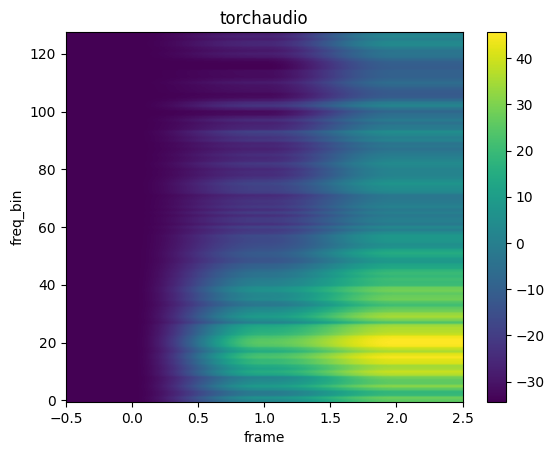

In [63]:
print_stats(spectrogram)
plot_spectrogram(spectrogram[0], title='torchaudio')

In [20]:
not_swallow_file2 = os.path.join('..', 'data', 'sound_datasets', 'urbansound8k', 'audio', 'fold10', '14468-3-0-2.wav')

In [58]:
nwaveform = process_audio_file(not_swallow_file2)
nwaveform = pad_trunc(nwaveform)
ntransform = torchaudio.transforms.MelSpectrogram(n_fft=16000, pad=16000-nwaveform.shape[1])
nspectrogram = ntransform(nwaveform)

Shape: (1, 128, 3)
Dtype: torch.float32
 - Max:     4159.299
 - Min:      0.211
 - Mean:    157.916
 - Std Dev: 353.646

tensor([[[3.2996e+00, 2.4405e+00, 2.6024e+00],
         [1.1108e+01, 4.4556e+00, 5.6971e+00],
         [1.0329e+01, 1.3800e+01, 8.7925e+00],
         [1.6396e+01, 2.7636e+01, 1.1844e+01],
         [2.5564e+02, 2.1859e+02, 7.1142e+01],
         [2.0706e+02, 2.0851e+02, 1.1234e+02],
         [1.4464e+02, 1.0040e+02, 1.5994e+02],
         [1.0444e+02, 1.0566e+02, 1.6089e+02],
         [5.1656e+02, 5.0649e+02, 7.1702e+02],
         [1.7717e+02, 1.2384e+02, 9.5680e+01],
         [1.4346e+02, 9.4787e+01, 5.1449e+01],
         [7.9447e+01, 8.6898e+01, 8.9095e+01],
         [1.1665e+02, 8.6470e+01, 1.6139e+02],
         [9.3271e+01, 3.6737e+01, 9.6136e+01],
         [1.2533e+02, 8.5888e+01, 1.4536e+02],
         [4.1321e+02, 3.0150e+02, 4.4982e+02],
         [6.2366e+02, 7.2344e+02, 9.1284e+02],
         [1.5026e+02, 1.5403e+02, 2.6090e+02],
         [1.7702e+02, 1.3840e+02,

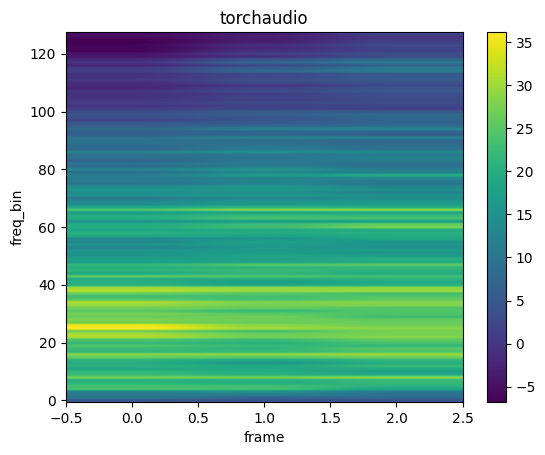

In [59]:
print_stats(nspectrogram)
plot_spectrogram(nspectrogram[0], title='torchaudio')

In [69]:
dataset = AudioDataset(df)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

In [70]:
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [91]:
batch_size = 16
num_cpus = os.cpu_count()

# DataLoader for training set
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# DataLoader for validation set
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# DataLoader for test set
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [83]:
class SwallowClassifier(nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [82]:

# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs, device):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')

In [93]:
model = SwallowClassifier()

In [94]:
num_epochs=100   # Just for demo, adjust this higher.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training(model, train_loader, num_epochs, device)

Epoch: 0, Loss: 2.21, Accuracy: 0.14
Epoch: 1, Loss: 2.13, Accuracy: 0.27
Epoch: 2, Loss: 2.07, Accuracy: 0.49
Epoch: 3, Loss: 1.96, Accuracy: 0.63
Epoch: 4, Loss: 1.92, Accuracy: 0.69
Epoch: 5, Loss: 1.77, Accuracy: 0.74
Epoch: 6, Loss: 1.70, Accuracy: 0.73
Epoch: 7, Loss: 1.51, Accuracy: 0.79
Epoch: 8, Loss: 1.41, Accuracy: 0.79
Epoch: 9, Loss: 1.34, Accuracy: 0.80
Epoch: 10, Loss: 1.29, Accuracy: 0.77
Epoch: 11, Loss: 1.17, Accuracy: 0.82
Epoch: 12, Loss: 1.07, Accuracy: 0.81
Epoch: 13, Loss: 1.00, Accuracy: 0.85
Epoch: 14, Loss: 0.96, Accuracy: 0.85
Epoch: 15, Loss: 1.10, Accuracy: 0.82
Epoch: 16, Loss: 0.84, Accuracy: 0.86
Epoch: 17, Loss: 0.84, Accuracy: 0.83
Epoch: 18, Loss: 0.91, Accuracy: 0.85
Epoch: 19, Loss: 0.79, Accuracy: 0.84
Epoch: 20, Loss: 0.71, Accuracy: 0.85
Epoch: 21, Loss: 0.71, Accuracy: 0.85
Epoch: 22, Loss: 0.66, Accuracy: 0.85
Epoch: 23, Loss: 0.62, Accuracy: 0.84
Epoch: 24, Loss: 0.55, Accuracy: 0.86
Epoch: 25, Loss: 0.45, Accuracy: 0.88
Epoch: 26, Loss: 0.53,

In [89]:
def inference(model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

In [96]:
inference(model, test_loader)

Accuracy: 0.83, Total items: 36
